<a href="https://colab.research.google.com/github/manola1109/Time-Series-Forecasting-v1/blob/main/Energy_Consumption_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook', font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 6)

# Display all columns
pd.set_option('display.max_columns', None)

# Load data from URL
url = "/content/energy consumption.csv"
energy = pd.read_csv(url, header=0, names=['Date', 'Consumption'])

# Convert date and set as index
energy['Date'] = pd.to_datetime(energy['Date'])
energy.set_index('Date', inplace=True)
energy.index.freq = 'MS'  # Monthly Start frequency

# Check data
print("Data Overview:")
print(energy.head())
print(f"\nData Range: {energy.index.min()} to {energy.index.max()}")
print(f"Total Months: {len(energy)}")
print(f"Missing Values: {energy.isnull().sum().sum()}")

Data Overview:
            Consumption
Date                   
1939-01-01       3.3842
1939-02-01       3.4100
1939-03-01       3.4875
1939-04-01       3.5133
1939-05-01       3.5133

Data Range: 1939-01-01 00:00:00 to 2019-09-01 00:00:00
Total Months: 969
Missing Values: 0


<ipython-input-1-f29f2deefc1c>:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  energy['Date'] = pd.to_datetime(energy['Date'])


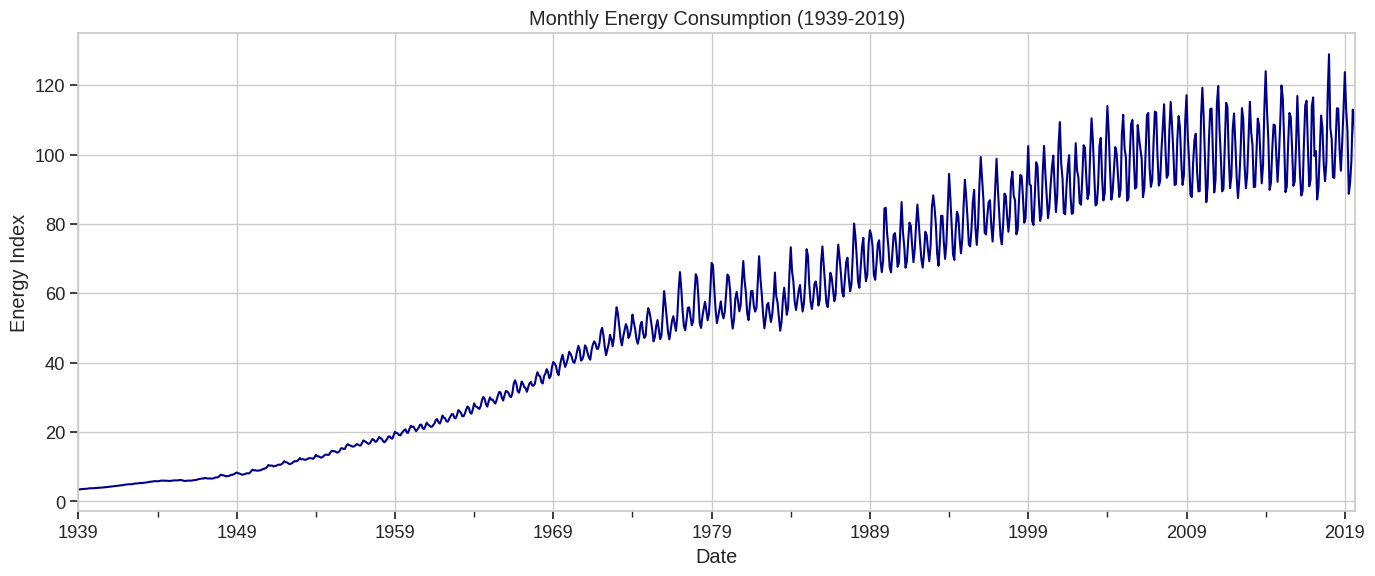

In [2]:
# Plot raw time series
plt.figure(figsize=(14, 6))
energy['Consumption'].plot(title='Monthly Energy Consumption (1939-2019)', color='darkblue')
plt.xlabel('Date')
plt.ylabel('Energy Index')
plt.tight_layout()
plt.show()

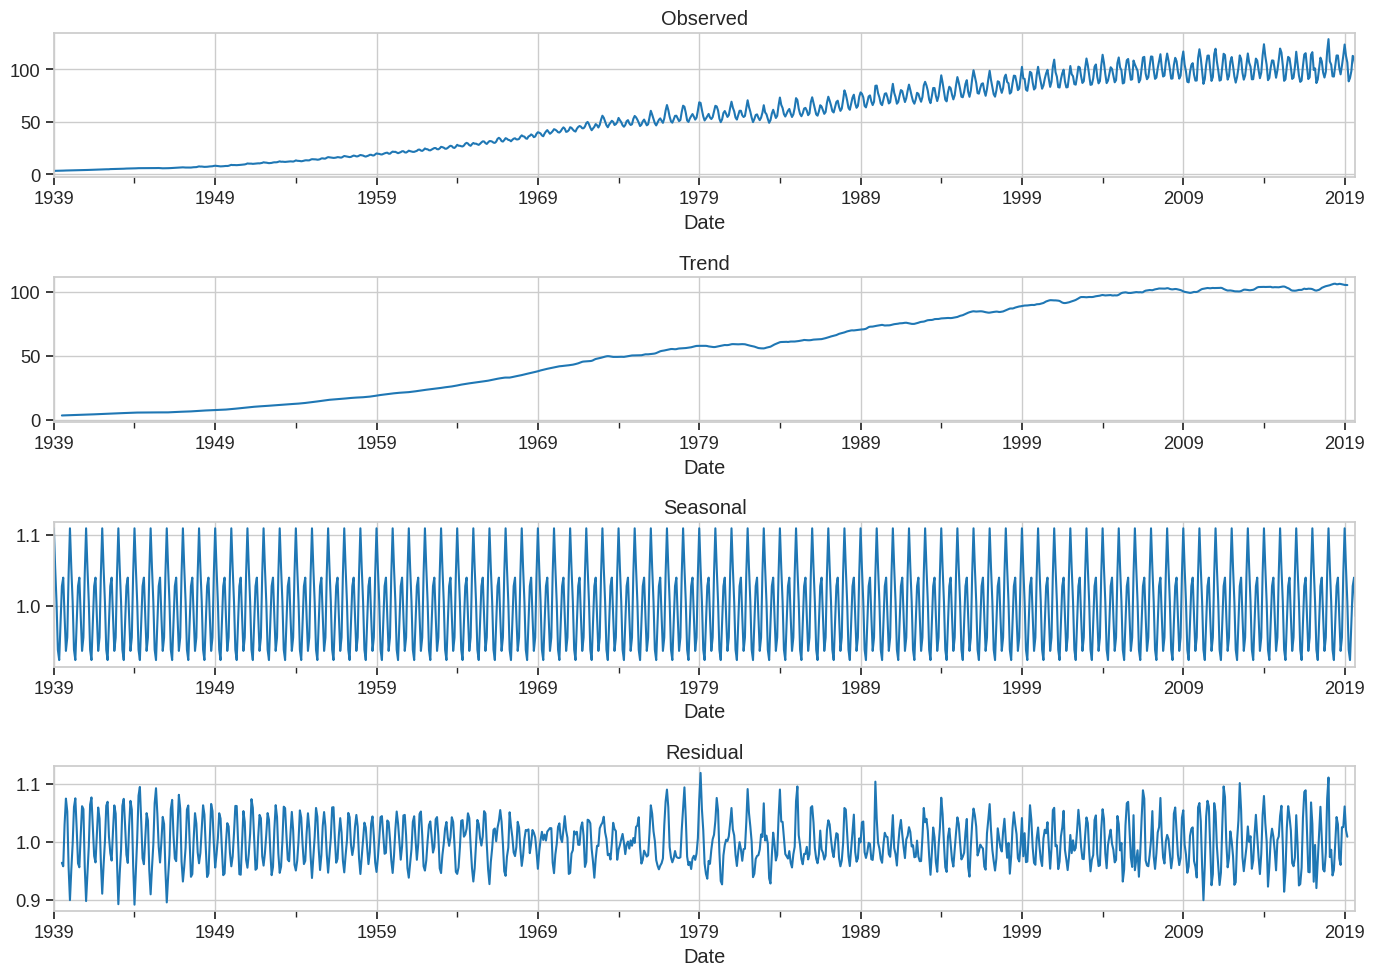

In [3]:
# Time series decomposition
decomposition = seasonal_decompose(energy['Consumption'], model='multiplicative', period=12)

plt.figure(figsize=(14, 10))
plt.subplot(4, 1, 1)
decomposition.observed.plot(title='Observed')
plt.subplot(4, 1, 2)
decomposition.trend.plot(title='Trend')
plt.subplot(4, 1, 3)
decomposition.seasonal.plot(title='Seasonal')
plt.subplot(4, 1, 4)
decomposition.resid.plot(title='Residual')
plt.tight_layout()
plt.show()

In [4]:
# Stationarity check (ADF Test)
def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')

    if result[1] <= 0.05:
        print("Reject null hypothesis - Data is stationary")
    else:
        print("Fail to reject null hypothesis - Data is non-stationary")

print("ADF Test for Original Series:")
adf_test(energy['Consumption'])

# Differencing for stationarity
energy['Diff_1'] = energy['Consumption'].diff()
print("\nADF Test for First Difference:")
adf_test(energy['Diff_1'])

ADF Test for Original Series:
ADF Statistic: -0.3562
p-value: 0.9172
Critical Values:
	1%: -3.4373
	5%: -2.8646
	10%: -2.5684
Fail to reject null hypothesis - Data is non-stationary

ADF Test for First Difference:
ADF Statistic: -10.0206
p-value: 0.0000
Critical Values:
	1%: -3.4373
	5%: -2.8646
	10%: -2.5684
Reject null hypothesis - Data is stationary


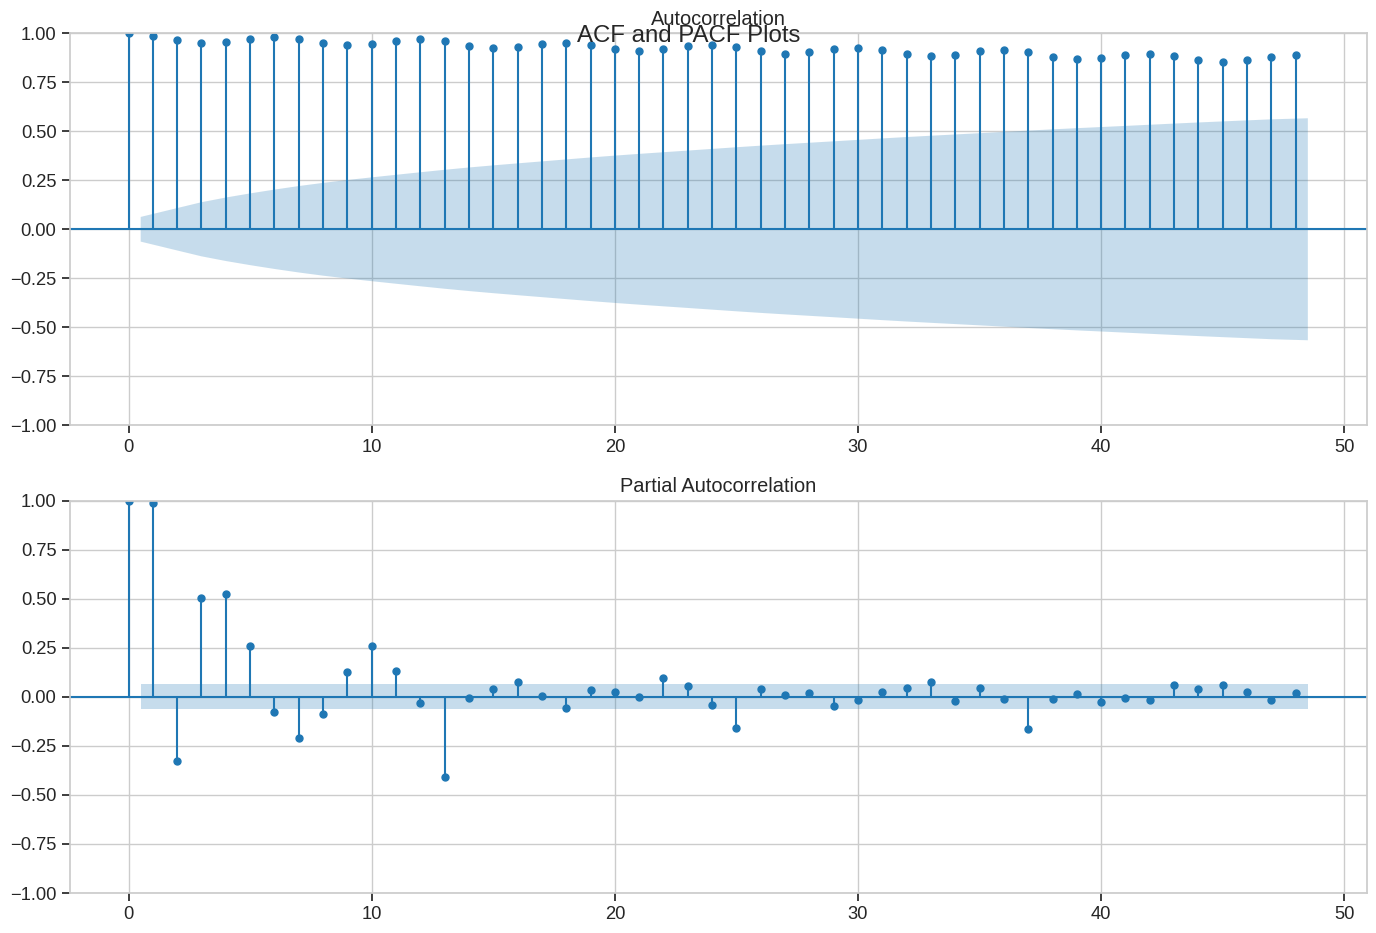

In [5]:
# ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
plot_acf(energy['Consumption'].dropna(), lags=48, ax=ax1)
plot_pacf(energy['Consumption'].dropna(), lags=48, ax=ax2, method='ywm')
plt.suptitle('ACF and PACF Plots', y=0.92)
plt.tight_layout()
plt.show()

In [6]:
# Train-validation split
train = energy.loc[:'2016-12']
validation = energy.loc['2017-01':'2019-09']

print(f"Train size: {len(train)} months")
print(f"Validation size: {len(validation)} months")

Train size: 936 months
Validation size: 33 months


In [7]:
# Evaluation metrics function
def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}

# Store results
results = {}

<ipython-input-8-c47d080f7e5e>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  naive_forecast = pd.Series([train['Consumption'][-1]] * len(validation), index=validation.index)


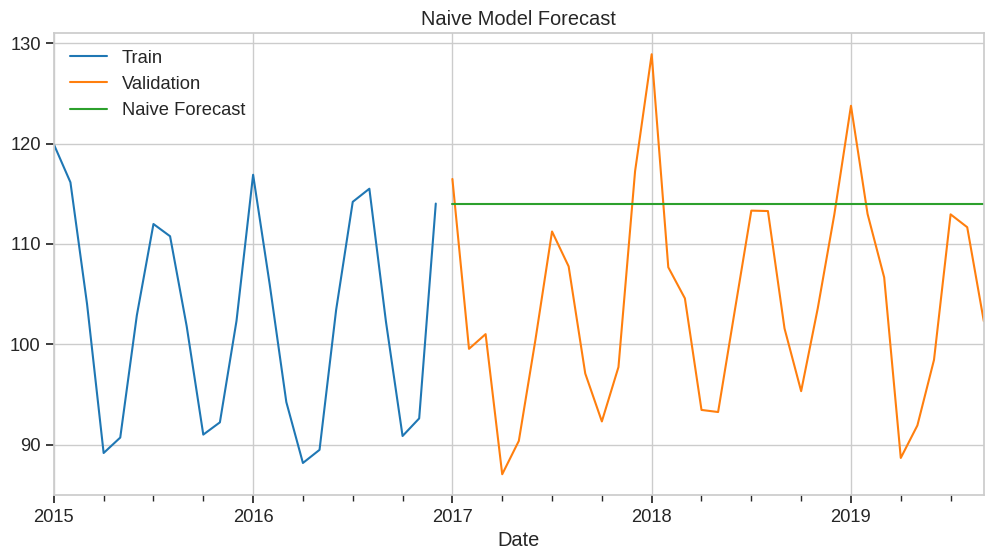

In [8]:
# Naive Forecast
naive_forecast = pd.Series([train['Consumption'][-1]] * len(validation), index=validation.index)
results['Naive'] = evaluate_forecast(validation['Consumption'], naive_forecast)

# Plot naive forecast
plt.figure(figsize=(12, 6))
train['Consumption'].iloc[-24:].plot(label='Train')
validation['Consumption'].plot(label='Validation')
naive_forecast.plot(label='Naive Forecast')
plt.title('Naive Model Forecast')
plt.legend()
plt.show()

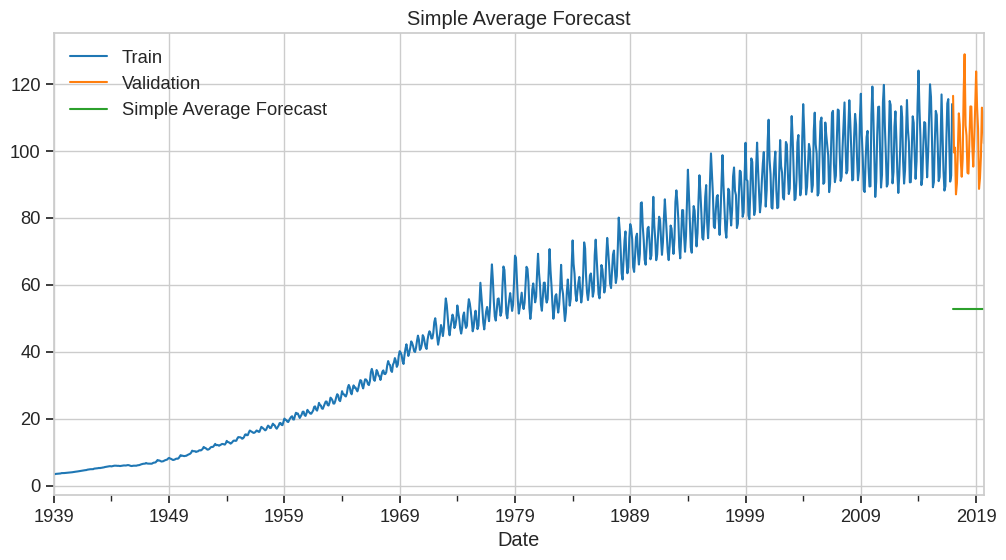

In [9]:
# Simple Average
avg_forecast = pd.Series([train['Consumption'].mean()] * len(validation), index=validation.index)
results['SimpleAvg'] = evaluate_forecast(validation['Consumption'], avg_forecast)

# Plot simple average forecast
plt.figure(figsize=(12, 6))
train['Consumption'].plot(label='Train')
validation['Consumption'].plot(label='Validation')
avg_forecast.plot(label='Simple Average Forecast')
plt.title('Simple Average Forecast')
plt.legend()
plt.show()

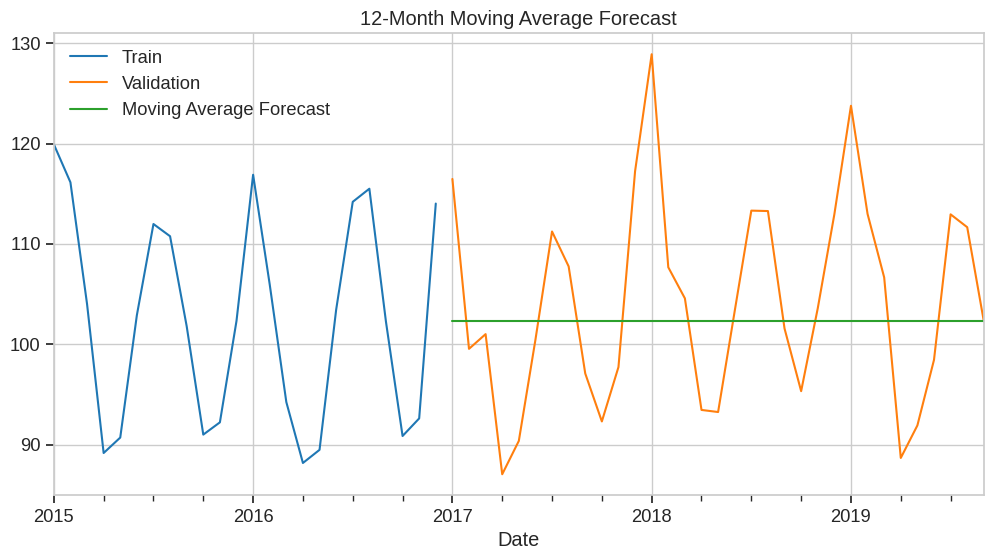

In [10]:
# Moving Average (12-month window)
ma_forecast = train['Consumption'].rolling(window=12).mean().iloc[-1]
ma_forecast = pd.Series([ma_forecast] * len(validation), index=validation.index)
results['MovingAvg'] = evaluate_forecast(validation['Consumption'], ma_forecast)

# Plot moving average forecast
plt.figure(figsize=(12, 6))
train['Consumption'].iloc[-24:].plot(label='Train')
validation['Consumption'].plot(label='Validation')
ma_forecast.plot(label='Moving Average Forecast')
plt.title('12-Month Moving Average Forecast')
plt.legend()
plt.show()

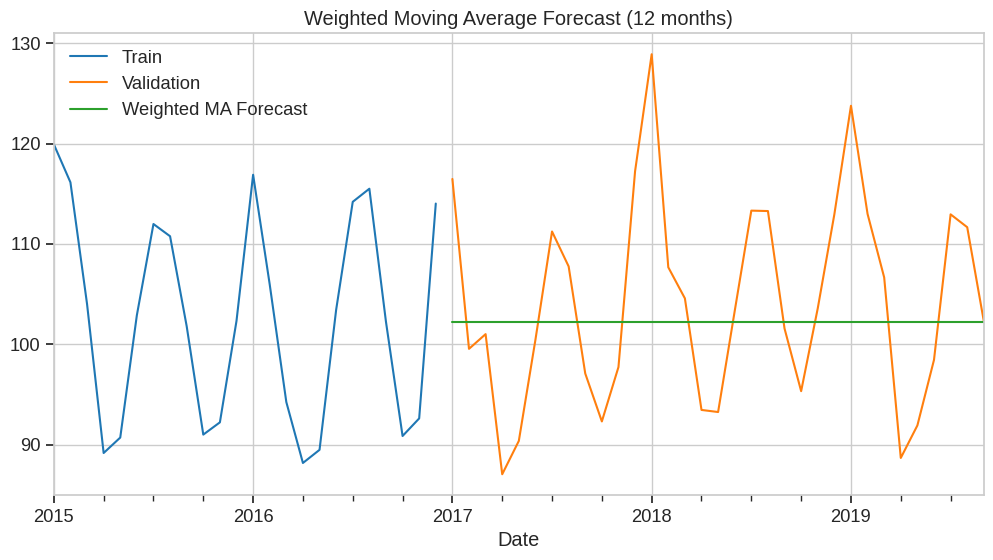

In [11]:
# Weighted Moving Average (linear weights)
def weighted_moving_average(series, window):
    weights = np.arange(1, window+1)
    return np.dot(series[-window:], weights) / weights.sum()

wma_value = weighted_moving_average(train['Consumption'], 12)
wma_forecast = pd.Series([wma_value] * len(validation), index=validation.index)
results['WMA'] = evaluate_forecast(validation['Consumption'], wma_forecast)

# Plot WMA forecast
plt.figure(figsize=(12, 6))
train['Consumption'].iloc[-24:].plot(label='Train')
validation['Consumption'].plot(label='Validation')
wma_forecast.plot(label='Weighted MA Forecast')
plt.title('Weighted Moving Average Forecast (12 months)')
plt.legend()
plt.show()

Best SES alpha: 0.4


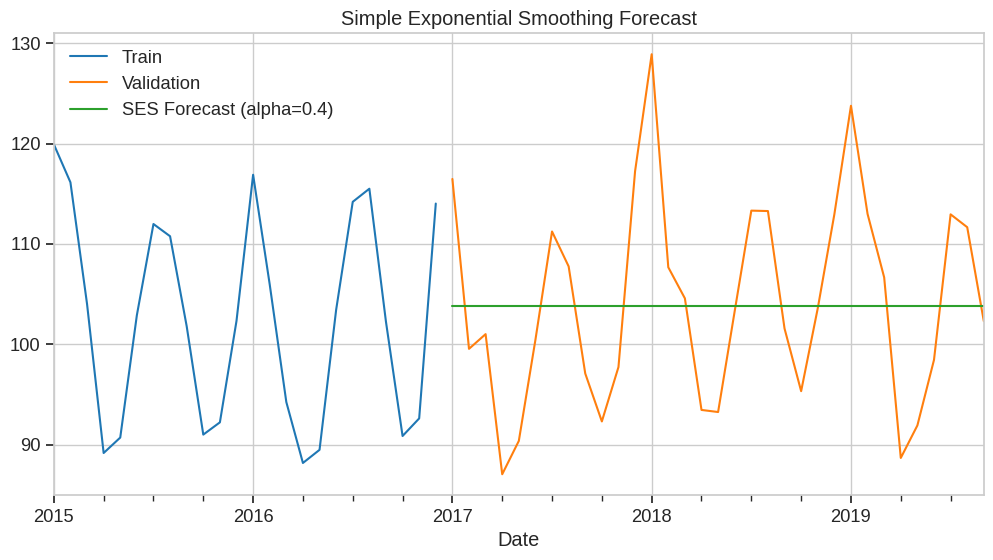

In [12]:
# Simple Exponential Smoothing (optimize alpha)
best_alpha = 0
best_rmse = float('inf')

for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    ses = ExponentialSmoothing(train['Consumption'],
                              trend=None,
                              seasonal=None).fit(smoothing_level=alpha)
    forecast = ses.forecast(len(validation))
    metrics = evaluate_forecast(validation['Consumption'], forecast)

    if metrics['RMSE'] < best_rmse:
        best_rmse = metrics['RMSE']
        best_alpha = alpha

# Final model with best alpha
ses_model = ExponentialSmoothing(train['Consumption'],
                                trend=None,
                                seasonal=None).fit(smoothing_level=best_alpha)
ses_forecast = ses_model.forecast(len(validation))
results['SES'] = evaluate_forecast(validation['Consumption'], ses_forecast)
print(f"Best SES alpha: {best_alpha}")

# Plot SES forecast
plt.figure(figsize=(12, 6))
train['Consumption'].iloc[-24:].plot(label='Train')
validation['Consumption'].plot(label='Validation')
ses_forecast.plot(label=f'SES Forecast (alpha={best_alpha:.1f})')
plt.title('Simple Exponential Smoothing Forecast')
plt.legend()
plt.show()

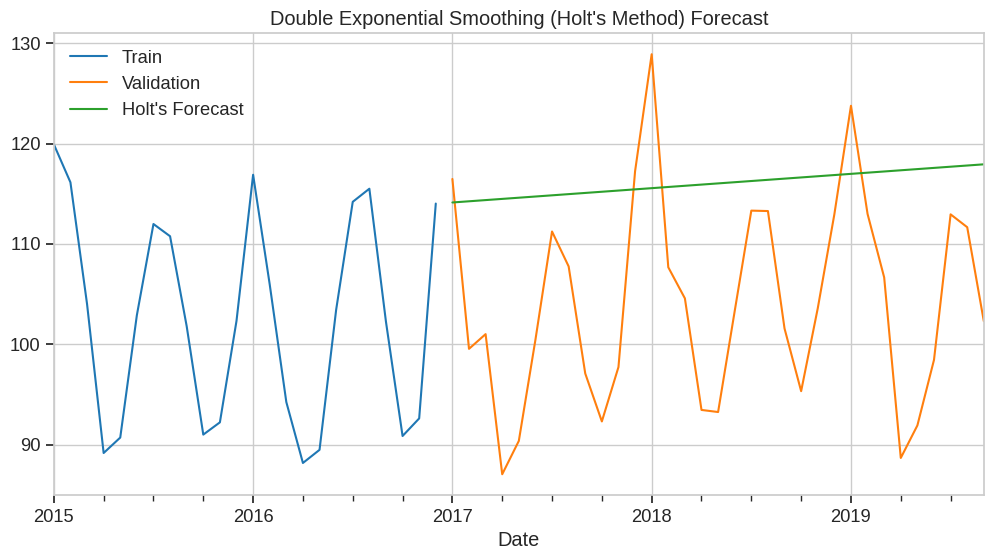

In [13]:
# Holt's Method (Double Exponential Smoothing)
holt_model = ExponentialSmoothing(train['Consumption'],
                                 trend='add',
                                 seasonal=None).fit()
holt_forecast = holt_model.forecast(len(validation))
results['Holt'] = evaluate_forecast(validation['Consumption'], holt_forecast)

# Plot Holt's forecast
plt.figure(figsize=(12, 6))
train['Consumption'].iloc[-24:].plot(label='Train')
validation['Consumption'].plot(label='Validation')
holt_forecast.plot(label='Holt\'s Forecast')
plt.title('Double Exponential Smoothing (Holt\'s Method) Forecast')
plt.legend()
plt.show()

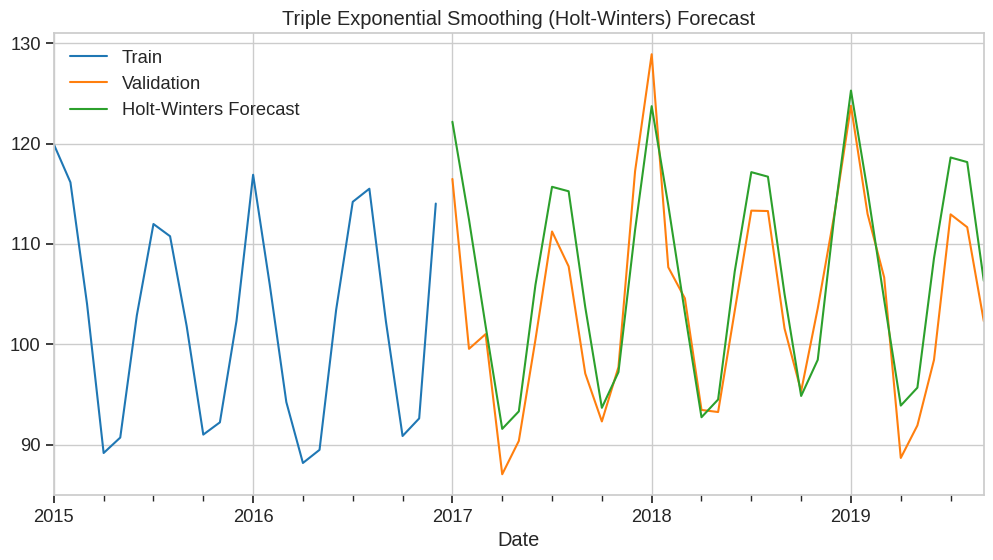

In [14]:
# Holt-Winters (Triple Exponential Smoothing)
hw_model = ExponentialSmoothing(train['Consumption'],
                               trend='add',
                               seasonal='mul',
                               seasonal_periods=12).fit()
hw_forecast = hw_model.forecast(len(validation))
results['HoltWinters'] = evaluate_forecast(validation['Consumption'], hw_forecast)

# Plot Holt-Winters forecast
plt.figure(figsize=(12, 6))
train['Consumption'].iloc[-24:].plot(label='Train')
validation['Consumption'].plot(label='Validation')
hw_forecast.plot(label='Holt-Winters Forecast')
plt.title('Triple Exponential Smoothing (Holt-Winters) Forecast')
plt.legend()
plt.show()

<ipython-input-16-c33ced51b54d>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  validation_features['Lag12'].fillna(last_train_lag, inplace=True)


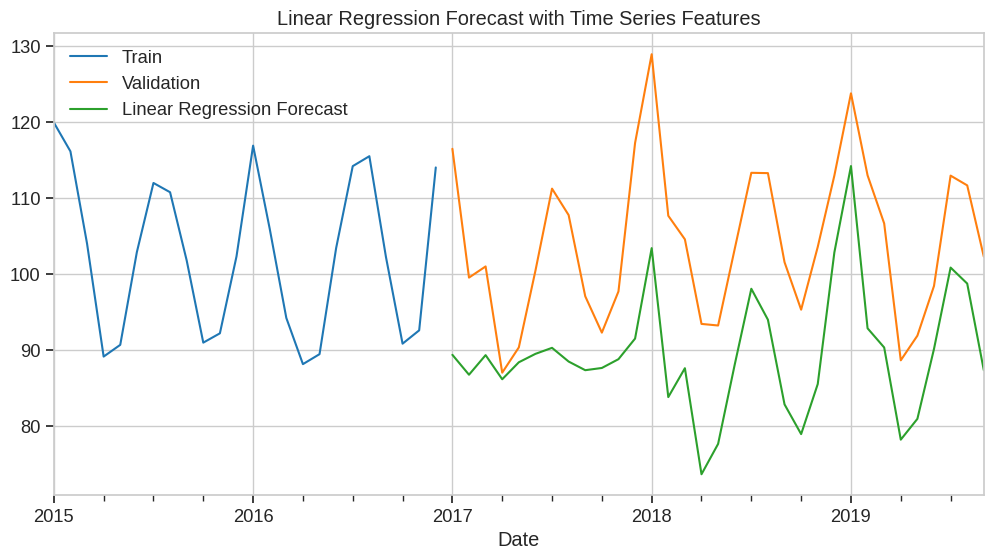

In [16]:
# Linear Regression with Time Series Features
def create_features(df):
    df = df.copy()
    df['Time'] = np.arange(len(df))
    df['Month'] = df.index.month
    return df

# Feature engineering
train_features = create_features(train)
validation_features = create_features(validation)

# One-hot encode months
train_features = pd.get_dummies(train_features, columns=['Month'], drop_first=True)
validation_features = pd.get_dummies(validation_features, columns=['Month'], drop_first=True)

# Add lags (t-12)
train_features['Lag12'] = train_features['Consumption'].shift(12)
validation_features['Lag12'] = validation_features['Consumption'].shift(12)

# Drop initial NA rows from training data
train_features.dropna(inplace=True)

# Fill NaNs in validation features 'Lag12' with the last non-null value from training 'Lag12'
# This is crucial for prediction where the initial validation points need the last historical lag
last_train_lag = train_features['Lag12'].iloc[-1]
validation_features['Lag12'].fillna(last_train_lag, inplace=True)

# Align columns - crucial if one-hot encoding resulted in different columns
# due to different months present in train vs validation
train_cols = X_train.columns
# Recreate X_train from the train_features after dropping NaNs
X_train = train_features.drop('Consumption', axis=1)

# Ensure validation features have the same columns as train features, filled with 0 for missing ones
X_val = validation_features.drop('Consumption', axis=1)
X_val = X_val.reindex(columns=train_cols, fill_value=0)


# Train model
lr = LinearRegression()
y_train = train_features['Consumption'] # y_train needs to correspond to the dropped rows in X_train
lr.fit(X_train, y_train)

# Predict on validation
lr_forecast = lr.predict(X_val)
results['LinearReg'] = evaluate_forecast(validation['Consumption'], lr_forecast)

# Plot Linear Regression forecast
plt.figure(figsize=(12, 6))
train['Consumption'].iloc[-24:].plot(label='Train')
validation['Consumption'].plot(label='Validation')
# The forecast array needs to be converted to a pandas Series with the correct index
pd.Series(lr_forecast, index=validation.index).plot(label='Linear Regression Forecast')
plt.title('Linear Regression Forecast with Time Series Features')
plt.legend()
plt.show()

Model Performance Comparison:


,MAE,MSE,RMSE,MAPE
HoltWinters,4.096030,24.576680,4.957487,3.944582
SES,8.353974,102.084895,10.103707,8.027193
MovingAvg,8.352996,105.581073,10.275265,7.907860
WMA,8.362135,105.988629,10.295078,7.908748
Naive,11.656194,198.377980,14.084672,11.910717
Holt,13.301633,240.452580,15.506533,13.548266
LinearReg,14.684346,255.658847,15.989335,13.858637
SimpleAvg,51.291253,2732.742163,52.275636,48.751419


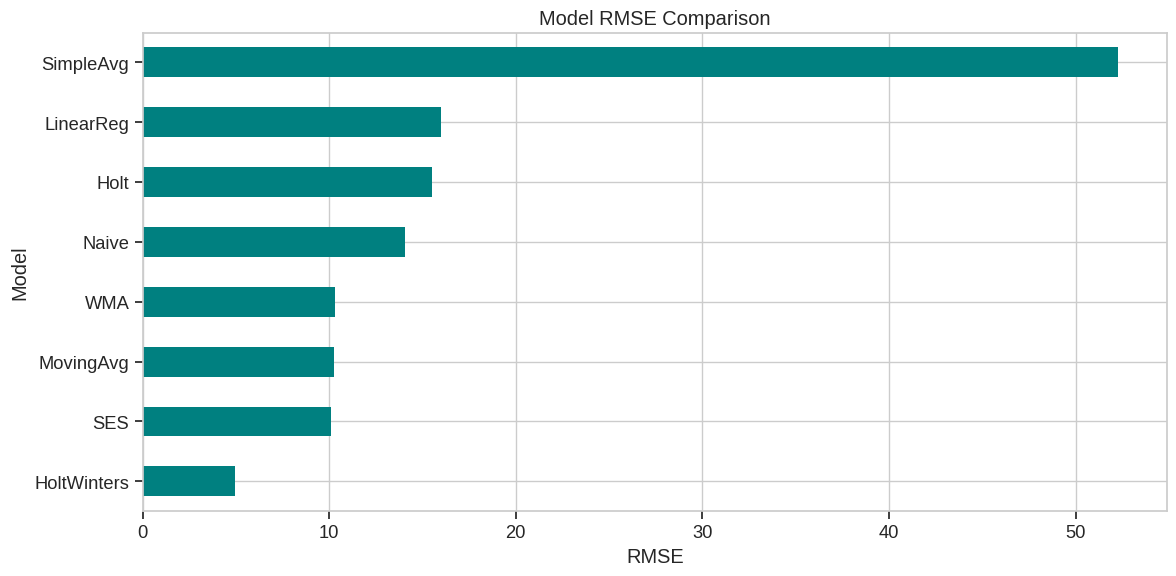

In [17]:
# Compile results
results_df = pd.DataFrame(results).T
results_df.sort_values(by='RMSE', inplace=True)
print("Model Performance Comparison:")
display(results_df)

# Visual comparison
plt.figure(figsize=(12, 6))
results_df['RMSE'].sort_values().plot(kind='barh', color='teal')
plt.title('Model RMSE Comparison')
plt.xlabel('RMSE')
plt.ylabel('Model')
plt.tight_layout()
plt.show()


Best Model: HoltWinters


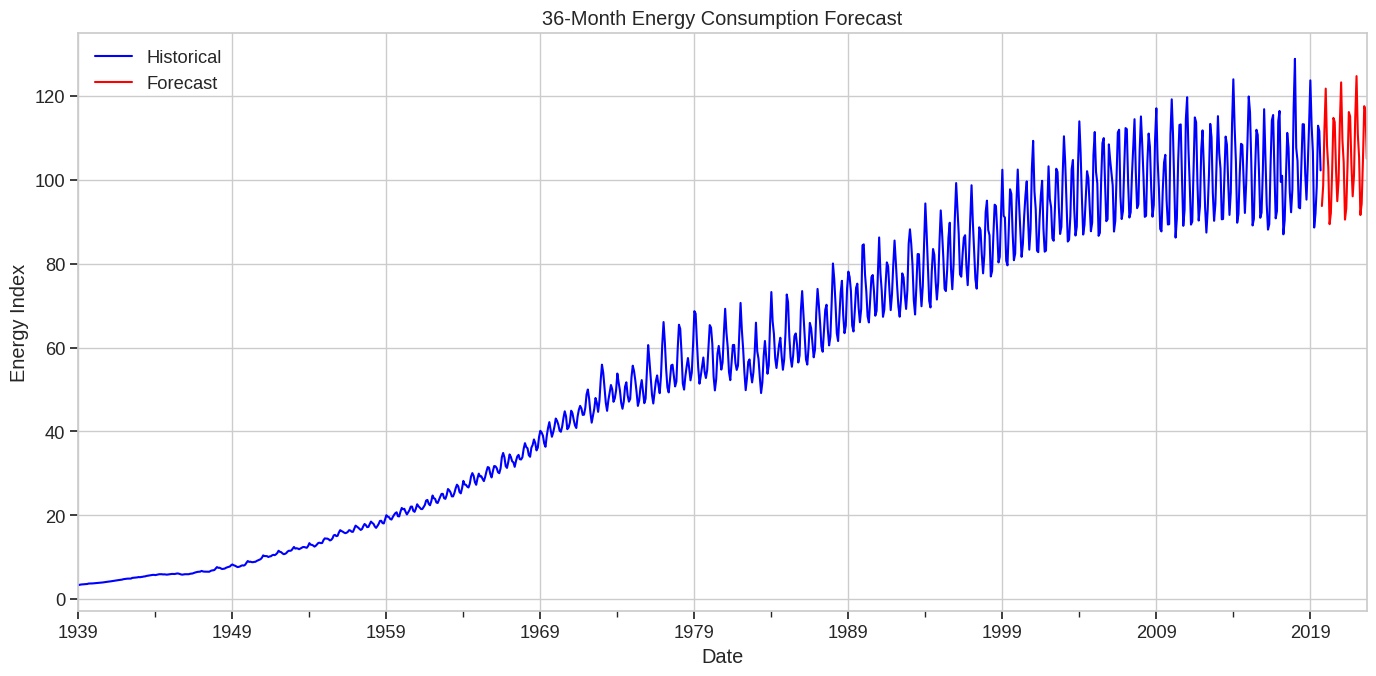


Forecast completed and saved to 'energy_forecast_2022.csv'
Forecast Summary:
         Forecast
count   36.000000
mean   105.660436
std      9.913417
min     89.458128
25%     97.964435
50%    104.478794
75%    114.060085
max    124.784847


In [18]:
# Retrain best model on full dataset
best_model_name = results_df.index[0]
print(f"\nBest Model: {best_model_name}")

if best_model_name == 'HoltWinters':
    # Holt-Winters model
    final_model = ExponentialSmoothing(energy['Consumption'],
                                      trend='add',
                                      seasonal='mul',
                                      seasonal_periods=12).fit()
    forecast = final_model.forecast(36)

elif best_model_name == 'LinearReg':
    # Linear Regression model
    full_data = create_features(energy)
    full_data = pd.get_dummies(full_data, columns=['Month'], drop_first=True)
    full_data['Lag12'] = full_data['Consumption'].shift(12)
    full_data.dropna(inplace=True)

    lr_full = LinearRegression()
    X_full = full_data.drop('Consumption', axis=1)
    y_full = full_data['Consumption']
    lr_full.fit(X_full, y_full)

    # Create future dataframe
    last_date = energy.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=36, freq='MS')
    future_df = pd.DataFrame(index=future_dates)
    future_df['Consumption'] = np.nan
    future_features = create_features(future_df)
    future_features = pd.get_dummies(future_features, columns=['Month'], drop_first=True)

    # Generate lags recursively
    forecast_vals = []
    current_lag = energy['Consumption'][-12]  # t-12 value

    for i in range(36):
        future_features.iloc[i, 1] = i + len(energy)  # Time index
        future_features.iloc[i, -1] = current_lag  # Set lag12

        # Predict next value
        pred = lr_full.predict(future_features.iloc[[i]])[0]
        forecast_vals.append(pred)

        # Update lag for next prediction
        if i >= 11:
            current_lag = forecast_vals[i-11]
        elif i == 0:
            current_lag = energy['Consumption'][-11]  # t-11 for next prediction

    forecast = pd.Series(forecast_vals, index=future_dates)
else:
    # For simplicity, use Holt-Winters if not LinearReg
    final_model = ExponentialSmoothing(energy['Consumption'],
                                      trend='add',
                                      seasonal='mul',
                                      seasonal_periods=12).fit()
    forecast = final_model.forecast(36)

# Plot final forecast
plt.figure(figsize=(14, 7))
energy['Consumption'].plot(label='Historical', color='blue')
forecast.plot(label='Forecast', color='red', title='36-Month Energy Consumption Forecast')
plt.xlabel('Date')
plt.ylabel('Energy Index')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save forecasts
forecast_df = pd.DataFrame(forecast)
forecast_df.columns = ['Forecast']
forecast_df.to_csv('energy_forecast_2022.csv')
print("\nForecast completed and saved to 'energy_forecast_2022.csv'")
print("Forecast Summary:")
print(forecast_df.describe())